In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import skew

In [8]:
family = pd.DataFrame(pd.read_csv("./city_day.csv"))
family = family.dropna()
df = family
family.head()
#Chỉ số bụi - ô nhiễm khí -> Xylene; AQI chất lượng kk; nhóm kk

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
2123,Amaravati,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2124,Amaravati,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
2125,Amaravati,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
2126,Amaravati,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate
2127,Amaravati,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,109.74,0.21,4.71,0.08,173.0,Moderate


In [9]:

compositional_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']

family = family[['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','AQI']]
total_household_income = family['AQI']
#family = family[(family != 0).all(axis=1)]

# Tách dữ liệu thành phần
compositional_data = family[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
2123,0.203576,0.311367,0.003601,0.051269,0.030211,0.026810,0.000300,0.038114,0.317844,0.000500,0.016256,0.000150
2124,0.189839,0.312827,0.003054,0.063021,0.035995,0.024918,0.000339,0.065348,0.284662,0.000533,0.019270,0.000194
2125,0.197350,0.300872,0.014674,0.068592,0.048404,0.028704,0.000245,0.074684,0.248599,0.000645,0.016965,0.000267
2126,0.164623,0.266993,0.006566,0.072000,0.043631,0.029293,0.000231,0.048735,0.354435,0.000436,0.012876,0.000180
2127,0.195849,0.310353,0.014134,0.062698,0.044834,0.033105,0.000432,0.028511,0.296571,0.000568,0.012729,0.000216


In [10]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

clr_compositional_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.701882,3.126812,-1.332850,1.322932,0.794058,0.674618,-3.817757,1.026430,3.147402,-3.306931,0.174309,-4.510904
1,2.538639,3.038113,-1.591053,1.435932,0.875835,0.508036,-3.788277,1.472190,2.943763,-3.336292,0.251007,-4.347893
2,2.398767,2.820474,-0.200099,1.341968,0.993364,0.470834,-4.294444,1.427060,2.629632,-3.325043,-0.055081,-4.207432
3,2.411851,2.895415,-0.809833,1.584861,1.083961,0.685526,-4.157786,1.194598,3.178717,-3.521797,-0.136411,-4.409101
4,2.464458,2.924826,-0.164303,1.325438,0.990086,0.686812,-3.651296,0.537412,2.879400,-3.379362,-0.269026,-4.344443


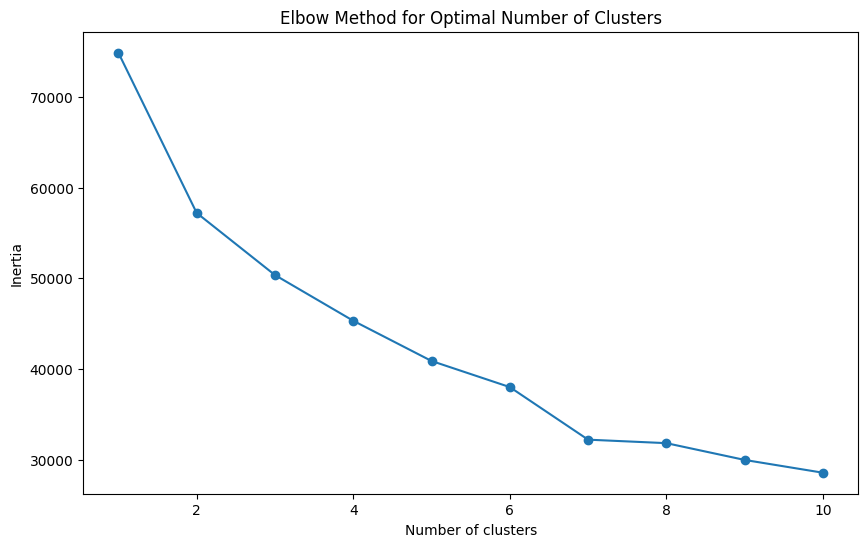

In [11]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
clr_compositional_df_scaled = scaler.fit_transform(clr_compositional_data)

# Tìm số lượng cụm tối ưu bằng phương pháp Elbow
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(clr_compositional_df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

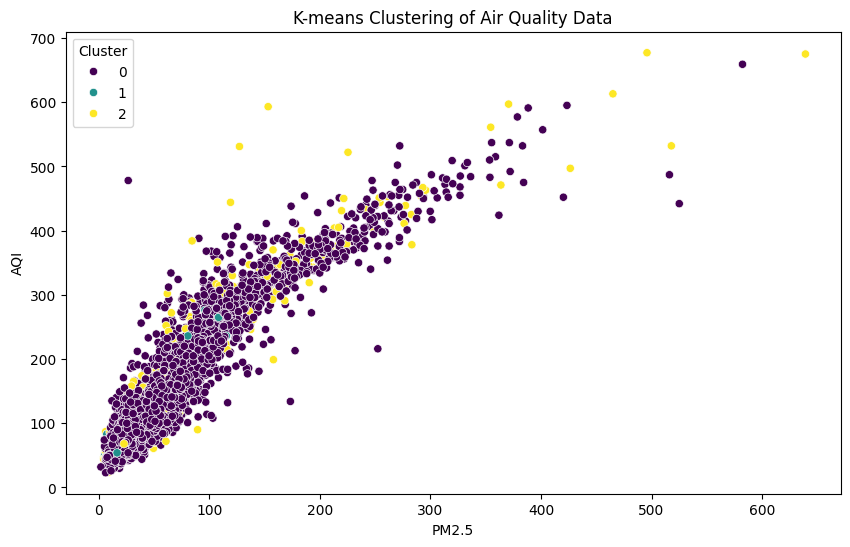

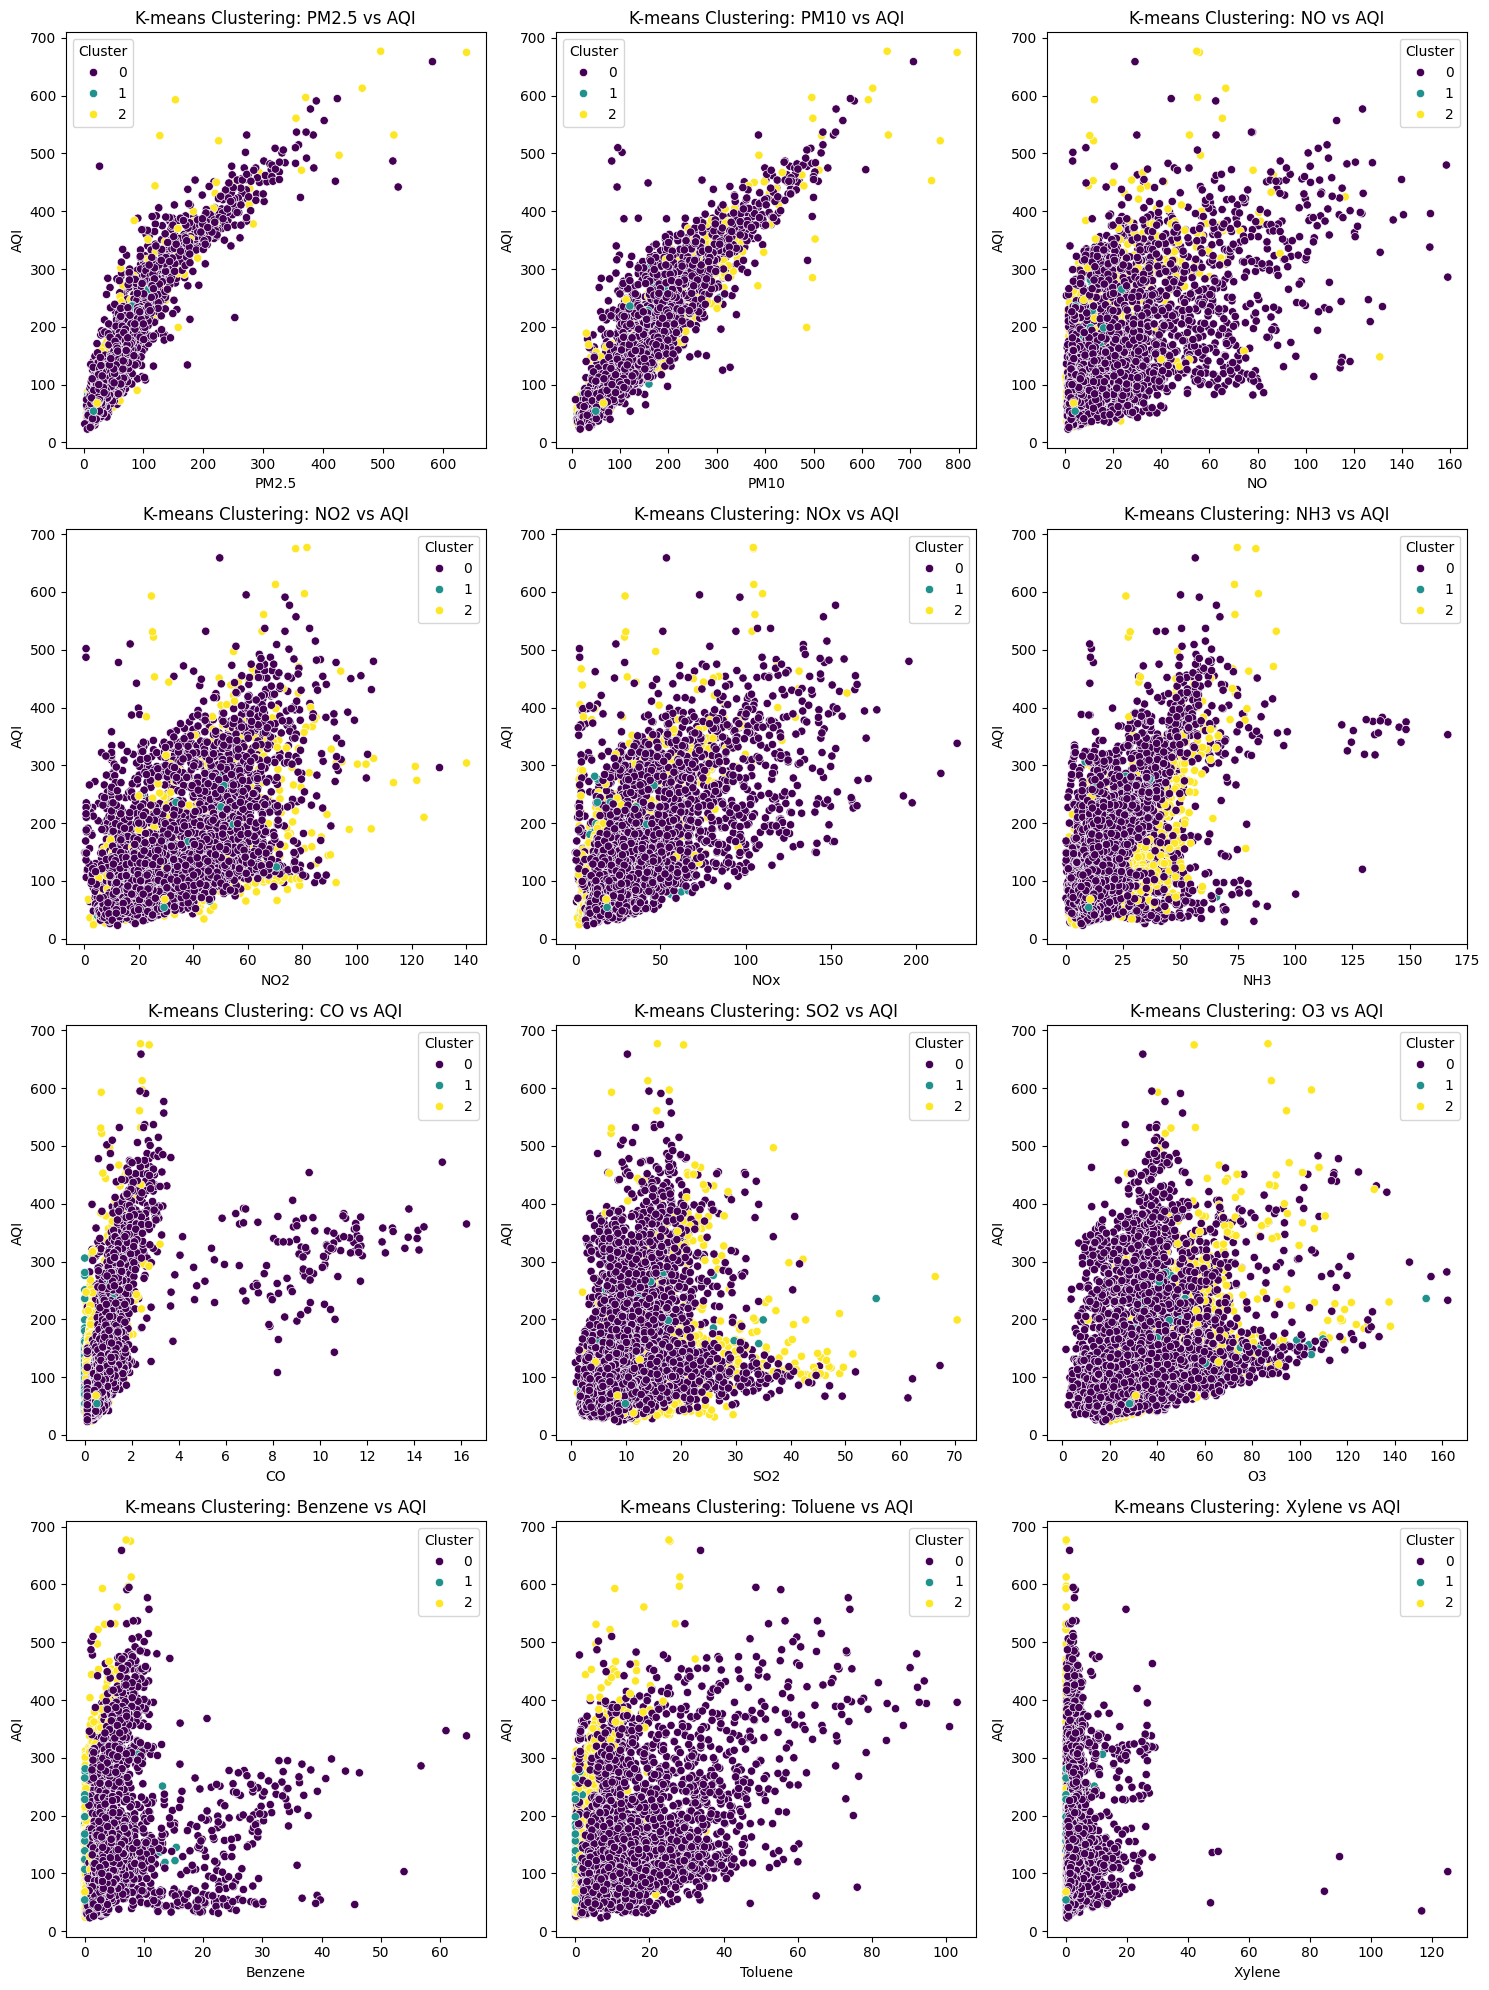

In [12]:
 #Từ biểu đồ Elbow, chọn số cụm tối ưu (giả sử là 3)
optimal_clusters = 3

# Thực hiện phân cụm K-means với số cụm tối ưu
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(clr_compositional_df_scaled)

# Trực quan hóa các cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PM2.5'], y=df['AQI'], hue=df['Cluster'], palette='viridis')
plt.title('K-means Clustering of Air Quality Data')
plt.xlabel('PM2.5')
plt.ylabel('AQI')
plt.legend(title='Cluster')
plt.show()

# Trực quan hóa các cụm với các biến khác
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(compositional_cols):
    sns.scatterplot(x=df[col], y=df['AQI'], hue=df['Cluster'], palette='viridis', ax=axes[i])
    axes[i].set_title(f'K-means Clustering: {col} vs AQI')

plt.tight_layout()
plt.show()

In [14]:
# Đánh giá mô hình phân cụm
sil_score = silhouette_score(clr_compositional_df_scaled, df['Cluster'])
db_score = davies_bouldin_score(clr_compositional_df_scaled, df['Cluster'])
ch_score = calinski_harabasz_score(clr_compositional_df_scaled, df['Cluster'])

NameError: name 'silhouette_score' is not defined